<img src='Cover5-01.png'>

# План семинара

- **Самые используемые классификаторы и их особенности**
- **Оценка качества классификации**
- **Отбор признаков**
- **От алгоритма "из коробки" до хорошего качества**

Сначала загрузим нужные нам библиотеки:

In [2]:
from collections import Counter, defaultdict
from copy import deepcopy
from operator import itemgetter
from random import shuffle, normalvariate, SystemRandom

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pylab, gridspec, pyplot as plt
from matplotlib.colors import ListedColormap

from IPython.display import Image

from sklearn.metrics import accuracy_score
from sklearn import datasets, model_selection
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.neighbors.base import _get_weights
%matplotlib inline

Также выгрузим датасеты:

In [3]:
f3=pd.read_csv('3f.txt')
f2=pd.read_csv('2f.txt')

### Описание датасетов

- **f3** Каждая из N строк содержит 216 чисел - число вхождений триграмм (триграммы отсортированы лексикографически).
- **f2** Каждая из N строк содержит 36 чисел - число вхождений биграмм (биграммы отсортированы лексикографически).

**Признаки**

- 'RecCode' --- код ЭКГ записи
- 'ObslCode' --- код обследования

Подряд идущим записям ЭКГ одного и того же человека (или записям с разных отведений) приписывался один и тот же номер обследования. Все строки с одинаковым номером обследования должны целиком быть в обучении или контроле.

Остальные признаки обозначаются F(номер). Их смысл зависит от датасета.

**Классы**

AZ,AP,AR,AKH,AM,TT,BL,CHD,VD,GD,GR,GB,DZH,DG,ZHO,ZHK,KHE,ZHR,ZD,IB,IR,
KS,KYA,KI,LO,MO,MN,MT,MME,MK,MR,PT,PG,PZH,PK,PU,PP,PZ,PS,PR,PB,Cr,
RZH,RI,RD,RL,RU,RM,OMZH,RN,RO,RPZH,RR,RP,RSH,RSHCH,RYA,RV,RZ,SR,SD,SZ,USHCH,
MP,KHB,KHG,NF,KHKH,KHKHE,BK,EKP,ES,EM,ESH,YAZH,YAB,ALG,OGM,GPT,GPZ,PZHS,RVM,
EP,OL,LFG,OPR,OTK,OSHCHZH,OM,A,BR,VDE,GDE,YABE,GBE,IBE,SDE,MKE,ZHKE,USHCHE,
KHGE,DZHE,IM,RES,OK,RDO,RLO,RYAO,RPO,RRO,DES,AR,OP,MTE,ROE,KYAO,MM,YAK,
MGR,MPO,TSP,AD,EAP,EAKH,EA,EAT,EGD,TRS,GBK,TBTS,TB?,TBO,TBA,OPE,OZH,no

**Из них нас интересует:**

In [6]:
classlist=['AZ','VD','GB','ZHK','IB','MK','MME','SD','USHCH',
           'KHGE','KHKHE','EA','EAP','EAKH','YABE']

Сгенерируем список для работы с признаками:

In [7]:
listF=[]
for i in range(200):
    f = 'F' + str(i+1)
    listF.append(f)

Посмотрим на датасет с биграммами:

In [8]:
f2.head()

F1  F2  F3  F4  F5  F6  F7  F8  F9  F10 ...  EGD  TRS  GBK  TBTS  TB?  TBO  \
0  22  14  17  46  23  21  21   9   2    6 ...    0    0    0     0    0    0   
1  12  15  29  12  13  16  18   7  17   20 ...    0    0    0     0    0    0   
2  63   4  32  35  11  39  11   2   2    3 ...    0    0    0     0    0    0   
3  79   2  22  42  24  24   7   3  10    0 ...    0    0    0     0    0    0   
4  63  10  40  19   5  37   4   0   1    6 ...    0    0    0     0    0    0   

   TBA  OPE  OZH  no  
0    0    0    0   0  
1    0    0    0   0  
2    0    0    0   0  
3    0    0    0   0  
4    0    0    0   0  

[5 rows x 174 columns]

В нем, как и в датасете с триграммами, содержатся все классы, в том числе те, которые нам не интересны.
Удалим ненужные классы:

In [9]:
for column in f2.columns:
    if column not in class_list+list_f:
        f2 = f2.drop([column], axis=1)
f2.head()

F1  F2  F3  F4  F5  F6  F7  F8  F9  F10 ...  MME  MK  SD  USHCH  KHKHE  \
0  22  14  17  46  23  21  21   9   2    6 ...    0   0   0      0      0   
1  12  15  29  12  13  16  18   7  17   20 ...    0   0   0      0      0   
2  63   4  32  35  11  39  11   2   2    3 ...    0   0   0      0      0   
3  79   2  22  42  24  24   7   3  10    0 ...    0   0   0      0      0   
4  63  10  40  19   5  37   4   0   1    6 ...    0   0   0      0      0   

   YABE  KHGE  EAP  EAKH  EA  
0     0     0    0     0   0  
1     0     0    0     0   0  
2     0     0    0     0   0  
3     0     0    0     0   0  
4     0     0    0     0   0  

[5 rows x 51 columns]

In [10]:
for column in f3.columns:
    if column not in class_list+list_f:
        f3 = f3.drop([column], axis=1)
f3.head()

F1  F2  F3  F4  F5  F6  F7  F8  F9  F10 ...  MME  MK  SD  USHCH  KHKHE  \
0   0   4   1   8   1   8   2   2   1    2 ...    0   0   0      0      0   
1   1   5   4   0   1   1   3   0   3    3 ...    0   0   0      0      0   
2   9   0   8  14   5  26   0   1   0    2 ...    0   0   0      0      0   
3  12   0   8  30  13  16   0   0   1    0 ...    0   0   0      0      0   
4  12   6  20   6   3  16   2   0   0    2 ...    0   0   0      0      0   

   YABE  KHGE  EAP  EAKH  EA  
0     0     0    0     0   0  
1     0     0    0     0   0  
2     0     0    0     0   0  
3     0     0    0     0   0  
4     0     0    0     0   0  

[5 rows x 215 columns]

# Изучение библиотеки scikit-learn

<img src='sklearn_cheat_sheet.png'>

# Самые используемые классификаторы

- **линейные алгоритмы**: SVM, логистическая регрессия
- **композиционные методы**: случайный лес, бустинг
- **метрические алгоритмы**: k ближайших соседей

**Линейные алгоритмы** разделяют классы многомерной плоскостью -- самой простой возможной по форме разделяющей поверхностью. Особенно хороши тогда, когда мало данных. Простота препятствует переобучению. Кстати, то что в одном признаковом пространстве -- плоскость, то в другом может быть и чем-то более сложным. (Например, дана прямая $x=y$ на плоскости. как она будет выглядеть в координатах ($\sqrt{x},y$)? Такой переход к более удобному пространству признаков в SVM называется kernel trick.

**Композиционные методы** это попытка заставить различные алгоритмы компенсировать недостатки друг друга. В случае деревьев -- очень удачная. Самое слабое место деревьев в том, что они очень сильно перестраиваются если поменять обучающую выборку буквально слегка. Для построения композиций лучше всего использовать как можно более разные алгоритмы. Бустинг не обязательно строить над деревьями, но для него случайные деревья тоже хорошо подходят.

**Метрические методы** хороши тогда, кога мы знаем как мерять расстояние. Например, когда мы можем нарисовать картинку в двухмерии и увидеть глазами что точки одного класса расположены близко. Большое количество шумовых признаков как правило делает почти все точки одинаково далекими друг от друга и алгоритм работает плохо.

# Оценка качества классификации, Cross-Validation

## Cross-Validation в sklearn

документация: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

## Разовое разбиение данных на обучение и тест (hold-out) с помощью train_test_split
<img src = 'img/TrainValidate.png'>

** Split dataset to train\validate (hold-out CV) ** 
  * split $X=\{x_i,y_i\}^\ell_{i=1} = X^m\cup X^k$ on 2 parts ($k+m = l$)
  * train $a = \mu(X^m).$
  * calculate quality measure $Q=Q(a,X^k)$

In [7]:
iris = datasets.load_iris()

In [8]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(iris.data, iris.target, 
                                                                                     test_size = 0.3)

In [9]:
#убедимся, что тестовая выборка действительно составляет 0.3 от всех данных
float(len(test_labels))/len(iris.data)

0.3

In [10]:
print ('Размер обучающей выборки: {} объектов \nРазмер тестовой выборки: {} объектов'.format(len(train_data),
                                                                                            len(test_data)))

Размер обучающей выборки: 105 объектов 
Размер тестовой выборки: 45 объектов


In [11]:
print ('Обучающая выборка:\n', train_data[:5],'\n')
print ('Тестовая выборка:\n', test_data[:5])

Обучающая выборка:
 [[ 7.2  3.6  6.1  2.5]
 [ 5.7  2.6  3.5  1. ]
 [ 6.7  2.5  5.8  1.8]
 [ 4.8  3.   1.4  0.3]
 [ 6.1  2.8  4.7  1.2]] 

Тестовая выборка:
 [[ 5.4  3.9  1.3  0.4]
 [ 5.1  3.5  1.4  0.2]
 [ 6.4  2.8  5.6  2.2]
 [ 6.9  3.1  4.9  1.5]
 [ 6.8  3.   5.5  2.1]]


In [12]:
print ('Метки классов на обучающей выборке:\n', train_labels, '\n')
print ('Метки классов на тестовой выборке:\n', test_labels)

Метки классов на обучающей выборке:
 [2 1 2 0 1 1 0 0 1 2 0 1 0 0 0 1 1 0 0 0 0 0 0 2 2 1 2 1 1 2 0 2 1 2 0 2 0
 0 2 0 2 2 1 2 0 2 0 1 1 0 0 2 0 0 1 1 0 1 2 1 1 2 1 2 1 1 2 1 1 0 1 1 1 0
 2 1 2 2 1 2 2 0 2 2 2 1 2 0 2 0 0 0 1 1 1 1 2 0 1 1 1 0 0 2 2] 

Метки классов на тестовой выборке:
 [0 0 2 1 2 1 2 0 1 1 0 1 1 2 1 2 2 0 2 2 2 2 0 0 2 0 0 0 1 2 2 1 2 0 1 0 2
 1 1 1 2 2 0 0 0]


** Вопрос: ** 
* Когда стоит пользоваться таким подходом при обучении алгоритмов?

## Стратегии проведения кросс-валидации

** Cross-validation **
   * repeat spitting for $N$ times 
   * calculate average empirical risk: 
$$CV(\mu,X^\ell)=\frac{1}{N}\sum_{n=1}^N Q(a_n,X^k_n)$$

   * types of CV
      - complete CV
      - k-fold CV

## KFold
<img src='img/k-fold.png'>

In [13]:
X=list(range(10))
kf = model_selection.KFold(n_splits=2)

for train_indices, test_indices in kf.split(X):
    print (train_indices, test_indices)

[5 6 7 8 9] [0 1 2 3 4]
[0 1 2 3 4] [5 6 7 8 9]


In [14]:
#многократный запуск приводит к различным разбиениям
kf = model_selection.KFold(n_splits=2,  shuffle=True)

for train_indices, test_indices in kf.split(X):
    print (train_indices, test_indices)

[0 1 3 4 7] [2 5 6 8 9]
[2 5 6 8 9] [0 1 3 4 7]


In [15]:
#многократный запуск приводит к одному и  тому же разбиению, результат запуска детерминированный
kf = model_selection.KFold(n_splits=2,  shuffle=True, random_state=1)

for train_indices, test_indices in kf.split(X):
    print (train_indices, test_indices)

[1 3 5 7 8] [0 2 4 6 9]
[0 2 4 6 9] [1 3 5 7 8]


#### StratifiedKFold

In [16]:
target = np.array([0] * 5 + [1] * 5)
print(target)
for train_indices, test_indices in model_selection.StratifiedKFold(n_splits = 2, shuffle = True, random_state = 0).split(X, target):
    print( train_indices, test_indices)

[0 0 0 0 0 1 1 1 1 1]
[3 4 8 9] [0 1 2 5 6 7]
[0 1 2 5 6 7] [3 4 8 9]


In [17]:
target = np.array([0, 1] * 5)
print(target)
for train_indices, test_indices in model_selection.StratifiedKFold(n_splits = 2, shuffle = True).split(X, target):
    print( train_indices, test_indices)

[0 1 0 1 0 1 0 1 0 1]
[1 2 3 8] [0 4 5 6 7 9]
[0 4 5 6 7 9] [1 2 3 8]


#### ShuffleSplit

In [18]:
for train_indices, test_indices in model_selection.ShuffleSplit(n_splits = 3, test_size=0.3).split(X):
    print( train_indices, test_indices)

[5 8 7 3 2 0 1] [6 4 9]
[8 2 0 3 7 6 9] [1 4 5]
[9 4 5 1 8 0 7] [6 2 3]


#### StratifiedShuffleSplit

In [19]:
target = np.array([0] * 5 + [1] * 5)
print (target)
for train_indices, test_indices in model_selection.StratifiedShuffleSplit(n_splits = 6, test_size=0.3).split(X, target):
    print (train_indices, test_indices)

[0 0 0 0 0 1 1 1 1 1]
[9 3 5 4 7 0 1] [2 6 8]
[8 4 9 0 1 6 7] [3 5 2]
[8 2 3 9 7 1 4] [6 5 0]
[7 2 1 6 8 5 4] [0 9 3]
[1 6 5 4 3 9 8] [7 0 2]
[7 5 9 4 3 2 8] [6 0 1]


#### Leave-One-Out

In [20]:
for train_indices, test_index in model_selection.LeaveOneOut().split(X):
    print (train_indices, test_index)

[1 2 3 4 5 6 7 8 9] [0]
[0 2 3 4 5 6 7 8 9] [1]
[0 1 3 4 5 6 7 8 9] [2]
[0 1 2 4 5 6 7 8 9] [3]
[0 1 2 3 5 6 7 8 9] [4]
[0 1 2 3 4 6 7 8 9] [5]
[0 1 2 3 4 5 7 8 9] [6]
[0 1 2 3 4 5 6 8 9] [7]
[0 1 2 3 4 5 6 7 9] [8]
[0 1 2 3 4 5 6 7 8] [9]


Больше стратегий проведения кросс-валидации доступно здесь: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators

# Разбиение выборки на train, validate и test
<img src='img/TrainTestValidate.png'>
** Вопрос ** зачем нужен ещё один samle (test-sample)?

In [21]:
L = 50
d = 1000

gen_train = pd.DataFrame.from_records([
        [ SystemRandom().randint(0,1)]+ [normalvariate(0, 1) for j in range(d)] 
        for i in range(L)
    ], columns = ['Label']+ ['F'+str(j)  for j in range(d)])

In [22]:
gen_train.head() # label - random Binary variable, columns -random variable from N(0,1)

Label        F0        F1        F2        F3        F4        F5  \
0      1  0.348229  0.443789  1.292348 -1.523752  1.875450 -1.159869   
1      0  0.933785  1.507449 -0.185544 -0.086111 -0.100338 -0.621870   
2      1 -1.417557 -0.914449 -0.868020 -0.257371 -0.589189  1.605649   
3      1  0.577591  0.376678 -0.338480 -0.287075  1.116187  0.398802   
4      1 -0.000940 -0.704815  0.071215 -0.795531 -0.364236  0.623482   

         F6        F7        F8    ...         F990      F991      F992  \
0  1.926653 -0.634562  0.459309    ...    -0.069475  1.272325 -0.792679   
1 -1.833181  1.421934  0.746079    ...     0.411850  0.525689  0.724250   
2 -0.273219 -1.484427 -0.595485    ...     0.571867 -1.253635  1.100234   
3 -0.373805  1.119899 -0.677687    ...    -0.410826 -0.548173  0.103562   
4 -0.253790 -0.134140 -0.327756    ...     1.019323  2.204323  0.295098   

       F993      F994      F995      F996      F997      F998      F999  
0 -0.670801  0.124543  2.118847  1.604161 -0.463920 -0.131458  0.408826  
1 -2.548628 -0.264431  0.100797  1.164372 -0.072911 -0.475365 -0.385527  
2 -0.375113 -0.588033  0.231365 -0.320608 -0.442241  0.536830  1.505920  
3  0.720782  0.562588 -1.181680 -0.575427  1.169453 -0.436938 -0.770544  
4 -0.464953 -0.295447 -0.369589 -1.297272  0.675036  1.485167  0.074665  

[5 rows x 1001 columns]

In [23]:
gen_train.groupby(['Label'])['Label'].count()

Label
0    25
1    25
Name: Label, dtype: int64

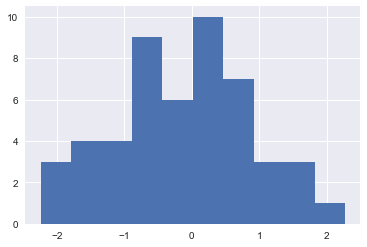

In [24]:
gen_train['F13'].hist()

In [25]:
def qFold_accuracy(x,y, estimator, cv_strategy):
    score = 0
    for train_indices, test_indices in cv_strategy.split(x):
        estimator.fit(x[train_indices], y[train_indices])
        score += estimator.score(x[test_indices], y[test_indices])
    return score/cv_strategy.get_n_splits()

## q-Fold для выбора лучшего признака

In [26]:
# Проводим эксперимент по нестройке классификатора, опирающегося на 1 признак

max_score = 0
f=0 
cv_k = 10

kf = model_selection.KFold(cv_k) 
for j in range(1,d+1):       # номер признака
    scrrr  = qFold_accuracy(np.asarray(gen_train[[gen_train.columns[j]]]),np.asarray(gen_train[['Label']]).ravel(),
                            KNeighborsClassifier(n_neighbors=3), kf)
#    print i,"-th feature = ",scrrr
    if(scrrr > max_score):
        max_score = scrrr
        f = j-1

In [27]:
# Точность при CV
print('Score on Validation Set (CV1) %.1f%%' % (max_score*100))
print('Best feature №:',f)

Score on Validation Set (CV1) 74.0%
Best feature №: 382


## Оценка точности на независимом сете

In [28]:
# estimation set
gen_test = pd.DataFrame.from_records([
        [ SystemRandom().randint(0,1)]+ [normalvariate(0, 1) for j in range(1)] 
        for i in range(100)
    ], columns = ['Label']+ ['F'+str(j)  for j in range(1)])

In [29]:
# True score on Test Set
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(np.asarray(gen_train[['F'+str(f)]]), np.asarray(gen_train[['Label']]))

print('Score on Validation Set (CV1) %.1f%%' % (100*accuracy_score(clf.predict(np.asarray(gen_test[['F0']])), np.asarray(gen_test[['Label']]))))

Score on Validation Set (CV1) 48.0%


/Users/flaren/anaconda/envs/MyPython3/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


# Отбор признаков

В наших примерах мы будем работать с набором данных, содержащим информацию о случаях сахарного диабета среди индейцев Пима (Pima Indians diabetes). Все признаки являются числовыми, а задача представляет собой двухклассовую классификацию.

### Одномерный отбор признаков

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
dataframe.head()

preg  plas  pres  skin  test  mass   pedi  age  class
0     6   148    72    35     0  33.6  0.627   50      1
1     1    85    66    29     0  26.6  0.351   31      0
2     8   183    64     0     0  23.3  0.672   32      1
3     1    89    66    23    94  28.1  0.167   21      0
4     0   137    40    35   168  43.1  2.288   33      1

В примере ниже используется критерий хи-квадрат (chi-squared test) для неотрицательных признаков, чтобы отобрать 4 лучших признака. Возможно использовать и другие критери. 

In [49]:
# feature extraction

test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)

# summarize scores

print(fit.scores_)


[  111.51969064  1411.88704064    17.60537322    53.10803984  2175.56527292
   127.66934333     5.39268155   181.30368904]


Мы видим оценки для каждого признака и 4 отобранных признака (с наивысшими оценками): plas, test, mass и age.

In [50]:
features = fit.transform(X)

# summarize selected features

print(features[:,:])

[[ 148.     0.    33.6   50. ]
 [  85.     0.    26.6   31. ]
 [ 183.     0.    23.3   32. ]
 ..., 
 [ 121.   112.    26.2   30. ]
 [ 126.     0.    30.1   47. ]
 [  93.     0.    30.4   23. ]]


#### Проверим качество различных моделей при использовании данного набора признаков

In [51]:
model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_2=LinearSVC(C=0.005, penalty="l1", dual=False)

In [52]:
# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)

dataframe.head()


preg  plas  pres  skin  test  mass   pedi  age  class
0     6   148    72    35     0  33.6  0.627   50      1
1     1    85    66    29     0  26.6  0.351   31      0
2     8   183    64     0     0  23.3  0.672   32      1
3     1    89    66    23    94  28.1  0.167   21      0
4     0   137    40    35   168  43.1  2.288   33      1

Оставим только plas, test, mass и age

In [53]:
select1=dataframe[['plas','test','mass','age','class']]
select1.head()

plas  test  mass  age  class
0   148     0  33.6   50      1
1    85     0  26.6   31      0
2   183     0  23.3   32      1
3    89    94  28.1   21      0
4   137   168  43.1   33      1

In [54]:
array = select1.values
X = array[:,0:4]
Y = array[:,4]

### Рекурсивное исключение признаков (Del)

In [55]:
# Feature Extraction with RFE
from pandas import read_csv
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# load data

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

In [56]:
# feature extraction

model = LogisticRegression()

rfe = RFE(model, 3)

fit = rfe.fit(X, Y)

print("Num Features: %d") % fit.n_features_

print("Selected Features: %s") % fit.support_

print("Feature Ranking: %s") % fit.ranking_

Num Features: 3
Selected Features: [ True False False False False  True  True False]
Feature Ranking: [1 2 3 5 6 1 1 4]


Мы видим, что в результате были отобраны 3 лучших признака: preg, mass, pedi. Отобранные признаки помечены значением «True» в массиве support_ и значением «1» в массиве ranking_.

#### Проверим качество различных моделей при использовании данного набора признаков

In [57]:
model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_3=LinearSVC(C=0.005, penalty="l1", dual=False)

In [58]:
# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)

dataframe.head()

preg  plas  pres  skin  test  mass   pedi  age  class
0     6   148    72    35     0  33.6  0.627   50      1
1     1    85    66    29     0  26.6  0.351   31      0
2     8   183    64     0     0  23.3  0.672   32      1
3     1    89    66    23    94  28.1  0.167   21      0
4     0   137    40    35   168  43.1  2.288   33      1

In [59]:
select2=dataframe[['preg','mass', 'pedi','class']]
select2.head()

preg  mass   pedi  class
0     6  33.6  0.627      1
1     1  26.6  0.351      0
2     8  23.3  0.672      1
3     1  28.1  0.167      0
4     0  43.1  2.288      1

In [60]:
array = select2.values
X = array[:,0:3]
Y = array[:,3]

In [61]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score


cv = KFold(n=len(Y), n_folds=5, shuffle=True, random_state=123)
CV1=cross_val_score(model_1, X, Y, cv=cv)
CV2=cross_val_score(model_2, X, Y, cv=cv)
CV3=cross_val_score(model_3, X, Y, cv=cv)

print CV1, mean(CV1)
print CV2, mean(CV2)
print CV3, mean(CV3)

[ 0.69480519  0.68181818  0.7012987   0.69281046  0.70588235] 0.695322977676
[ 0.67532468  0.63636364  0.66233766  0.73856209  0.62091503] 0.666700619642
[ 0.62987013  0.62337662  0.62987013  0.69934641  0.62745098] 0.641982853748


### Отбор на основе важности признаков

Ансамблевые алгоритмы на основе деревьев решений, такие как случайный лес (random forest), позволяют оценить важность признаков.

In [62]:
from sklearn.ensemble import ExtraTreesClassifier

# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

In [63]:
# feature extraction

model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.11538941  0.22378399  0.0884969   0.0844061   0.08726991  0.14856027
  0.11370912  0.13838429]


#### Проверим качество различных моделей при использовании данного набора признаков

In [64]:
model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_3=LinearSVC(C=0.005, penalty="l1", dual=False)

In [65]:
# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)

dataframe.head()

preg  plas  pres  skin  test  mass   pedi  age  class
0     6   148    72    35     0  33.6  0.627   50      1
1     1    85    66    29     0  26.6  0.351   31      0
2     8   183    64     0     0  23.3  0.672   32      1
3     1    89    66    23    94  28.1  0.167   21      0
4     0   137    40    35   168  43.1  2.288   33      1

In [66]:
select3=dataframe[['plas', 'mass', 'pedi', 'age', 'class']]
select3.head()

plas  mass   pedi  age  class
0   148  33.6  0.627   50      1
1    85  26.6  0.351   31      0
2   183  23.3  0.672   32      1
3    89  28.1  0.167   21      0
4   137  43.1  2.288   33      1

In [67]:
array = select3.values
X = array[:,0:4]
Y = array[:,4]

In [68]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score


cv = KFold(n=len(Y), n_folds=5, shuffle=True, random_state=123)
CV1=cross_val_score(model_1, X, Y, cv=cv)
CV2=cross_val_score(model_2, X, Y, cv=cv)
CV3=cross_val_score(model_3, X, Y, cv=cv)

print CV1, mean(CV1)
print CV2, mean(CV2)
print CV3, mean(CV3)

[ 0.77272727  0.77272727  0.73376623  0.77777778  0.80392157] 0.772184025125
[ 0.74675325  0.66233766  0.74025974  0.79738562  0.75816993] 0.740981240981
[ 0.63636364  0.57142857  0.64285714  0.7124183   0.63398693] 0.639410915882


### Метод главных компонент

In [69]:
from sklearn.decomposition import PCA

# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

In [70]:
# feature extraction

pca = PCA(n_components=3)
fit = pca.fit(X)
features = fit.transform(X)

# summarize components

print("Explained Variance: %s") % fit.explained_variance_ratio_
print(features[:,:])

Explained Variance: [ 0.88854663  0.06159078  0.02579012]
[[-75.71465491  35.95078264  -7.26078895]
 [-82.3582676  -28.90821322  -5.49667139]
 [-74.63064344  67.90649647  19.46180812]
 ..., 
 [ 32.11319827  -3.3766648   -1.58786446]
 [-80.21449431  14.18601977  12.3512639 ]
 [-81.30814972 -21.62149606  -8.15276833]]


#### Проверим качество различных моделей при использовании данного набора признаков

In [71]:
model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_3=LinearSVC(C=0.005, penalty="l1", dual=False)

In [72]:
X=features

In [73]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score


cv = KFold(n=len(Y), n_folds=5, shuffle=True, random_state=123)
CV1=cross_val_score(model_1, X, Y, cv=cv)
CV2=cross_val_score(model_2, X, Y, cv=cv)
CV3=cross_val_score(model_3, X, Y, cv=cv)

print CV1, mean(CV1)
print CV2, mean(CV2)
print CV3, mean(CV3)

[ 0.75974026  0.74675325  0.68181818  0.75816993  0.73856209] 0.737008742891
[ 0.74675325  0.6038961   0.68831169  0.76470588  0.71895425] 0.704524233936
[ 0.77272727  0.71428571  0.70779221  0.73856209  0.73202614] 0.73307868602


### L1-регуляризация

In [74]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
X.shape

(768, 8)

In [75]:
lsvc = LinearSVC(C=0.005, penalty="l1", dual=False).fit(X, Y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

(768, 5)

#### Проверим качество различных моделей при использовании данного набора признаков

In [76]:
model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_3=LinearSVC(C=0.005, penalty="l1", dual=False)

In [77]:
X=X_new

In [78]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score


cv = KFold(n=len(Y), n_folds=5, shuffle=True, random_state=123)
CV1=cross_val_score(model_1, X, Y, cv=cv)
CV2=cross_val_score(model_2, X, Y, cv=cv)
CV3=cross_val_score(model_3, X, Y, cv=cv)

print CV1, mean(CV1)
print CV2, mean(CV2)
print CV3, mean(CV3)

[ 0.79220779  0.75324675  0.69480519  0.77124183  0.78431373] 0.759163059163
[ 0.77922078  0.70779221  0.71428571  0.74509804  0.75816993] 0.740913335031
[ 0.69480519  0.62987013  0.64935065  0.7254902   0.68627451] 0.677158135982


In [ ]:
# Отбор признаков

В наших примерах мы будем работать с набором данных, содержащим информацию о случаях сахарного диабета среди индейцев Пима (Pima Indians diabetes). Все признаки являются числовыми, а задача представляет собой двухклассовую классификацию.

### Одномерный отбор признаков

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
dataframe.head()

В примере ниже используется критерий хи-квадрат (chi-squared test) для неотрицательных признаков, чтобы отобрать 4 лучших признака. Возможно использовать и другие критери. 

# feature extraction

test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)

# summarize scores

print(fit.scores_)


Мы видим оценки для каждого признака и 4 отобранных признака (с наивысшими оценками): plas, test, mass и age.

features = fit.transform(X)

# summarize selected features

print(features[:,:])

#### Проверим качество различных моделей при использовании данного набора признаков

model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_2=LinearSVC(C=0.005, penalty="l1", dual=False)

# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)

dataframe.head()


Оставим только plas, test, mass и age

select1=dataframe[['plas','test','mass','age','class']]
select1.head()

array = select1.values
X = array[:,0:4]
Y = array[:,4]

### Рекурсивное исключение признаков (Del)

# Feature Extraction with RFE
from pandas import read_csv
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# load data

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

# feature extraction

model = LogisticRegression()

rfe = RFE(model, 3)

fit = rfe.fit(X, Y)

print("Num Features: %d") % fit.n_features_

print("Selected Features: %s") % fit.support_

print("Feature Ranking: %s") % fit.ranking_

Мы видим, что в результате были отобраны 3 лучших признака: preg, mass, pedi. Отобранные признаки помечены значением «True» в массиве support_ и значением «1» в массиве ranking_.

#### Проверим качество различных моделей при использовании данного набора признаков

model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_3=LinearSVC(C=0.005, penalty="l1", dual=False)

# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)

dataframe.head()

select2=dataframe[['preg','mass', 'pedi','class']]
select2.head()

array = select2.values
X = array[:,0:3]
Y = array[:,3]

from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score


cv = KFold(n=len(Y), n_folds=5, shuffle=True, random_state=123)
CV1=cross_val_score(model_1, X, Y, cv=cv)
CV2=cross_val_score(model_2, X, Y, cv=cv)
CV3=cross_val_score(model_3, X, Y, cv=cv)

print CV1, mean(CV1)
print CV2, mean(CV2)
print CV3, mean(CV3)

### Отбор на основе важности признаков

Ансамблевые алгоритмы на основе деревьев решений, такие как случайный лес (random forest), позволяют оценить важность признаков.

from sklearn.ensemble import ExtraTreesClassifier

# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

# feature extraction

model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

#### Проверим качество различных моделей при использовании данного набора признаков

model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_3=LinearSVC(C=0.005, penalty="l1", dual=False)

# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)

dataframe.head()

select3=dataframe[['plas', 'mass', 'pedi', 'age', 'class']]
select3.head()

array = select3.values
X = array[:,0:4]
Y = array[:,4]

from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score


cv = KFold(n=len(Y), n_folds=5, shuffle=True, random_state=123)
CV1=cross_val_score(model_1, X, Y, cv=cv)
CV2=cross_val_score(model_2, X, Y, cv=cv)
CV3=cross_val_score(model_3, X, Y, cv=cv)

print CV1, mean(CV1)
print CV2, mean(CV2)
print CV3, mean(CV3)

### Метод главных компонент

from sklearn.decomposition import PCA

# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

# feature extraction

pca = PCA(n_components=3)
fit = pca.fit(X)
features = fit.transform(X)

# summarize components

print("Explained Variance: %s") % fit.explained_variance_ratio_
print(features[:,:])

#### Проверим качество различных моделей при использовании данного набора признаков

model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_3=LinearSVC(C=0.005, penalty="l1", dual=False)

X=features

from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score


cv = KFold(n=len(Y), n_folds=5, shuffle=True, random_state=123)
CV1=cross_val_score(model_1, X, Y, cv=cv)
CV2=cross_val_score(model_2, X, Y, cv=cv)
CV3=cross_val_score(model_3, X, Y, cv=cv)

print CV1, mean(CV1)
print CV2, mean(CV2)
print CV3, mean(CV3)

### L1-регуляризация

from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
X.shape

lsvc = LinearSVC(C=0.005, penalty="l1", dual=False).fit(X, Y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

#### Проверим качество различных моделей при использовании данного набора признаков

model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_3=LinearSVC(C=0.005, penalty="l1", dual=False)

X=X_new

from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score


cv = KFold(n=len(Y), n_folds=5, shuffle=True, random_state=123)
CV1=cross_val_score(model_1, X, Y, cv=cv)
CV2=cross_val_score(model_2, X, Y, cv=cv)
CV3=cross_val_score(model_3, X, Y, cv=cv)

print CV1, mean(CV1)
print CV2, mean(CV2)
print CV3, mean(CV3)